# Orientation error fit GP

In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

### 1. Import the data

From the `dependencies` folder

In [2]:
dependencies_folder = pathlib.Path().resolve().parent.joinpath("dependencies")

VelCurv = pd.read_csv(dependencies_folder.joinpath("VelCurv.csv"))

VelCurv_orient_masked = VelCurv[VelCurv["mask_orient"]]

x_data = np.vstack((VelCurv_orient_masked["curvatures"].to_numpy(), VelCurv_orient_masked["velocities"].to_numpy())).T
y_data = VelCurv_orient_masked["orient_errors"].to_numpy()

### 2. Fit the GP

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Ignore the GPU

### Import the `lib` directory
import pathlib
import sys

repo_directory = pathlib.Path().resolve().parents[1]
lib_module_dir = str(repo_directory.joinpath("lib"))
if lib_module_dir not in sys.path:
    sys.path.insert(0, str(repo_directory.joinpath("lib")))

from dual_gp_model_SVGP import DualGaussianProcessWrapper, make_train_test_split

2024-08-20 16:54:51.431631: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 16:54:52.193426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
EPOCHS: int = 1000  # 500
INDUCING_POINTS: int = 10
GRID_SIZE: int = 1000
MODEL_INFO: dict[str, str] = {"error": "orientation error", "param1": "curvature", "param2": "velocity"}

In [5]:
### Generate the model

GP_model = DualGaussianProcessWrapper(
    x_data=x_data,
    y_data=y_data,
    train_mask=make_train_test_split(len(y_data)),
    no_inducing_points=INDUCING_POINTS,
    use_lognormal=True,
    data_directory=str(pathlib.Path().resolve()),  # current directory
)

2024-08-20 16:54:55.985465: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-08-20 16:54:55.985507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: christiaan-HP-ZBook-Studio-G5
2024-08-20 16:54:55.985513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: christiaan-HP-ZBook-Studio-G5
2024-08-20 16:54:55.985630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 550.90.7
2024-08-20 16:54:55.985651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 550.90.7
2024-08-20 16:54:55.985657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 550.90.7


Going to train for 0 epochs...


0it [00:00, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting the posterior...


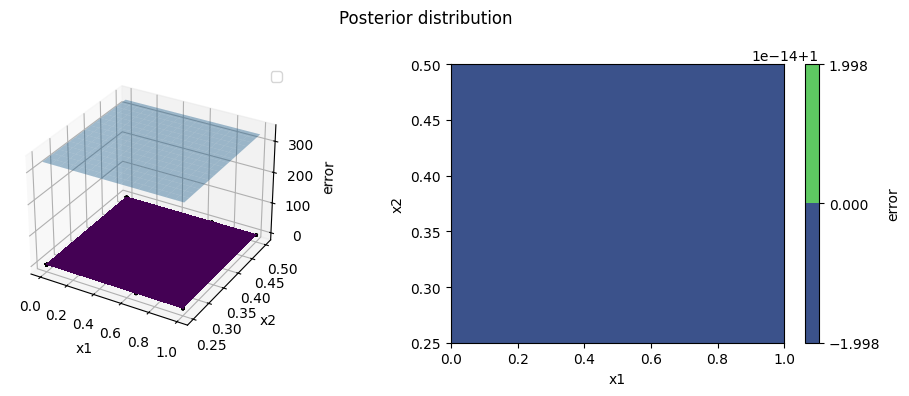

Generating the error model (interpolation grid)...


2024-08-20 16:55:01.761390: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6400000000 exceeds 10% of free system memory.
2024-08-20 16:55:03.107877: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6400000000 exceeds 10% of free system memory.
2024-08-20 16:55:05.060753: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.
2024-08-20 16:55:05.818966: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.
2024-08-20 16:55:06.582160: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3200000000 exceeds 10% of free system memory.


Saving the error model...
Done


In [6]:
print(f"Going to train for {EPOCHS} epochs...")
GP_model.train(epochs=EPOCHS)
print(f"Plotting the posterior...")
# GP_model.plot_posterior()
print(f"Generating the error model (interpolation grid)...")
GP_model.generate_error_model(grid_size=GRID_SIZE, model_info=MODEL_INFO)
print(f"Saving the error model...")
GP_model.save_error_model()
print("Done")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_215180/755030602.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis_cm = mpl.cm.get_cmap("viridis")


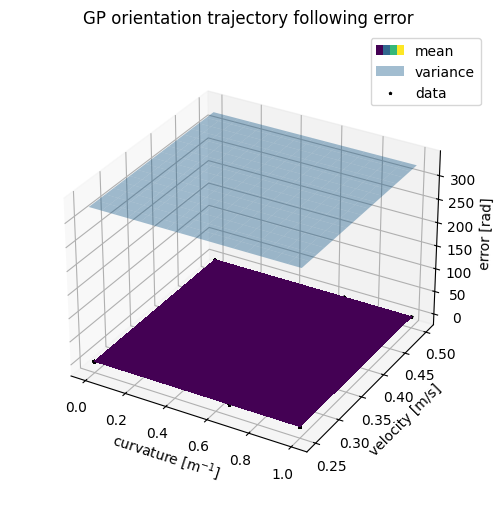

In [7]:
### Save the GP picture
from matplotlib.legend_handler import HandlerTuple

fig = GP_model.plot_posterior(return_fig=True)
ax1, ax2, cbar = fig.get_axes()
ax2.remove()
cbar.remove()
ax1.set_xlabel("curvature [m" + r"$^{-1}$" + "]")
ax1.set_ylabel("velocity [m/s]")
ax1.set_zlabel("error [rad]")

fig.suptitle("")
ax1.set_title("GP orientation trajectory following error")

ax1.set_box_aspect(aspect=None, zoom=0.88)

# ax1.legend([ax1.get_children()[1], ax1.get_children()[2]], ["mean", "variance"])

steps = 4
viridis_cm = mpl.cm.get_cmap("viridis")
colourmap_handle = []
for i in range(steps):
    colourmap_handle.append(mpl.patches.Patch(facecolor=viridis_cm(i / (steps - 1))))

ax1.legend(
    [colourmap_handle, ax1.get_children()[2], ax1.get_children()[0]],
    ["mean", "variance", "data"],
    handler_map={list: HandlerTuple(None, pad=0)},
)

fig.set_size_inches(10, 10)
fig.tight_layout()
fig.savefig("orientation_error_gp.pdf", bbox_inches="tight")
fig.savefig("orientation_error_gp.png", dpi=300, bbox_inches="tight")